# Import relevant libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.sparse.linalg import expm_multiply, eigsh
from scipy.sparse import csr_matrix, diags, eye

: 

# Define spin operators

We now consider an all-to-all, or infinite range, Ising model
\begin{equation}
H = -\frac{1}{N} \sum_{j<k}^N \sigma_j^x \sigma_k^x - \sum_j^N g(t) \sigma_j^z,
\end{equation}

The all-to-all nature of the interactions means that it is more convenient to write the Hamiltonian using collective spin operators
\begin{equation}
S_\alpha  = \frac{1}{2} \sum_n \sigma_n^\alpha
\end{equation}
where $\alpha \in \{x,y,z \}$. Using this choice we obtain the following
\begin{equation}
H = -\frac{2}{N} S_x^2 - 2 g S_z + \frac{1}{2} \mathbb{1}
\end{equation}

In the thermodynamic limit we can achieve control for the ground state via the AGP

\begin{equation}
A_\text{GS} = \frac{(2g - 1)\dot{g}}{4 N g(g-1)}\left( S_x S_y + S_y S_x\right)
\end{equation}

As discussed in the main text, this is an approximation to the exact AGP due to the fact that in deriving $A_\text{GS}$ we have employed the Holstein-Primakoff approximation.

In [2]:
def Sp(N: int):
    s = N/2
    m = np.arange(-s, s, dtype=float)                   # length N
    vals = np.sqrt(s*(s+1) - m*(m+1))
    row = np.arange(0, N, dtype=int)
    col = np.arange(1, N+1, dtype=int)
    return csr_matrix((vals, (row, col)), shape=(N+1, N+1), dtype=complex)

def Sm(N: int):
    s = N/2
    m = np.arange(-s+1, s+1, dtype=float)               # length N
    vals = np.sqrt(s*(s+1) - m*(m-1))
    row = np.arange(1, N+1, dtype=int)
    col = np.arange(0, N, dtype=int)
    return csr_matrix((vals, (row, col)), shape=(N+1, N+1), dtype=complex)

def Sz(N: int):
    s = N/2
    ms = np.arange(-s, s+1, dtype=float)                # diag eigenvalues m
    return diags(-ms.astype(complex), offsets=0, format='csr')

def Sx(N: int):
    return 0.5 * (Sp(N) + Sm(N))

def Sy(N: int):
    return (-0.5j) * (-Sm(N) + Sp(N))

In [3]:
def lmg(g0, gd, T, t, N):
    g = g0 + gd*(t/T)
    SxN = Sx(N)
    SzN = Sz(N)
    H = (-(2.0/N) * (SxN @ SxN)) - 2.0*g*SzN + 0.5*eye(N+1, dtype=complex, format='csr')
    return H  # sparse csr_matrix

# Free Hamiltonian evolution [no control]

In [4]:
nlist = np.array([10,50,80,100,150,200,250,300,400,500])
g0, gd, T = 2.0, -0.9, 1.0
steps = 1000
dt = T/steps

fid_list = np.zeros(np.shape(nlist)[0])
for i in tqdm(range(0,np.shape(nlist)[0])):
    N = nlist[i]
    ground = eigsh(lmg(g0,gd,T,0,N), k=1, which='SA')[1][:,0]
    target_state = eigsh(lmg(g0,gd,T,1,N), k=1, which='SA')[1][:,0]
    
    for j in range(0,steps):
        H = lmg(g0,gd,T,dt*j,N)
        ground_new = expm_multiply((-1j) * H * dt, ground)
        ground = ground_new
        if j == steps-1:
            fid_list[i] = abs(target_state @ ground)**2

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


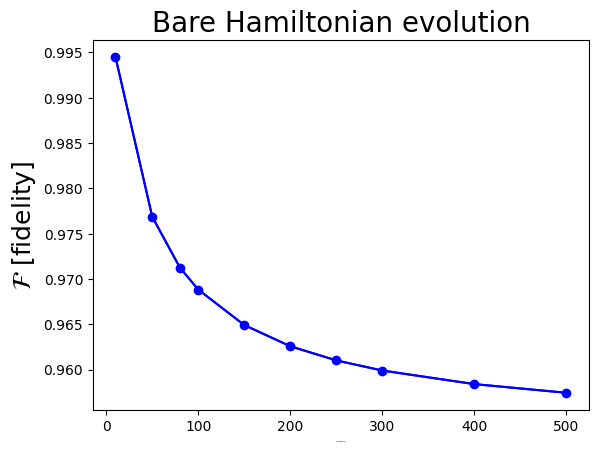

In [5]:
plt.plot(nlist,fid_list,marker = 'o',color = 'blue')
plt.plot(nlist,fid_list,color = 'blue')
plt.ylabel(r'$\mathcal{F}~[\rm{fidelity}]$',fontsize=18)
plt.xlabel(r'$N~[\rm{system size}]$',fontsize=1)
plt.title('Bare Hamiltonian evolution',fontsize=20)
plt.show()

# Dynamics with control

Next we include the approximate AGP

\begin{equation}
A_{GS} = \frac{(2g - 1)\dot{g}}{4 N g(g-1)}\left( S_x S_y + S_y S_x\right)
\end{equation}

In [6]:
def q(N: int):
    return (Sx(N) @ Sy(N)) + (Sy(N) @ Sx(N))

def agp_107(g0,gd,T,t,n,Q):
    g = g0 + gd*(t/T)
    coef = -((2*g-1)*(gd/T))/(4*n*g*(g-1))
    
    return coef*Q

In [7]:
nlist = np.array([10,50,80,100,150,200,250,300,400,500])
g0, gd, T = 2.0, -0.9, 1.0
steps = 1000
dt = T/steps

fid_list_2 = np.zeros(np.shape(nlist)[0])
for i in tqdm(range(0,np.shape(nlist)[0])):
    N = nlist[i]
    Q = q(N)
    ground = eigsh(lmg(g0,gd,T,0,N), k=1, which='SA')[1][:,0] 
    target_state = eigsh(lmg(g0,gd,T,1,N), k=1, which='SA')[1][:,0]
    
    for j in range(0,steps):
        H = lmg(g0,gd,T,dt*j,N) + agp_107(g0,gd,T,dt*j,N,Q)
        ground_new = expm_multiply((-1j) * H * dt, ground)
        ground = ground_new
        if j == steps-1: 
            fid_list_2[i] = abs(target_state @ ground)**2

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


# Recreate Figure 4(a)

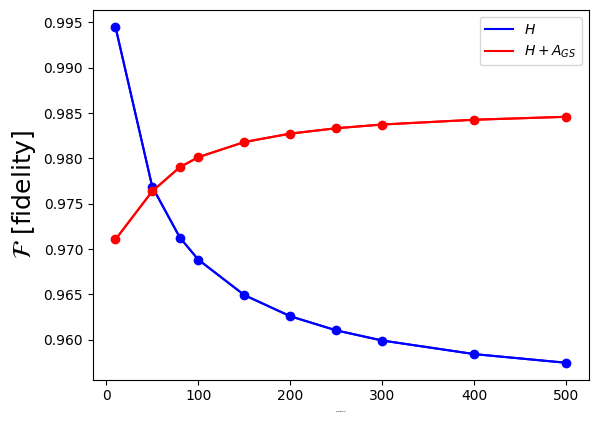

In [8]:
plt.plot(nlist,fid_list,marker = 'o',color = 'blue')
plt.plot(nlist,fid_list,color = 'blue',label = r'$H$')


plt.plot(nlist,fid_list_2,marker = 'o',color = 'red')
plt.plot(nlist,fid_list_2,color = 'red',label = r'$H + A_{GS}$')

plt.ylabel(r'$\mathcal{F}~[\rm{fidelity}]$',fontsize=18)
plt.xlabel(r'$N~[\rm{system size}]$',fontsize=1)
plt.legend()
plt.show()

# Pulse shaping profile

Finally we consider varying the ramp profile by changing the coefficient of $A_\text{GS}$, replacing it with a pulse profile that can be optimized. 

\begin{equation}
f(t) = \frac{\text{exp}(t^a)-b}{N}
\end{equation}

By sweeping over the parameters $a$ and $b$ we can find a profile that can achieve high fidelity performance. 

In [9]:
# With control
def f(a,b,t,n,Q):
    f = (np.exp(t**a)-b)/n
    return f*Q

In [10]:
N = 50
g0, gd, T = 2.0, -0.9, 1.0
steps = 1000
dt = T/steps

b_list = np.linspace(-1,1.3,20)
a_list  = np.linspace(1,10,20)

ground = eigsh(lmg(g0,gd,T,0,N), k=1, which='SA')[1][:,0]
target_state = eigsh(lmg(g0,gd,T,1,N), k=1, which='SA')[1][:,0]
Q = q(N)

output_data = np.zeros((20,20))
for i in tqdm(range(0,20)):
    for j in range(0,20):
        for k in range(0,steps):
            H = lmg(g0,gd,T,dt*k,N) + f(a_list[i],b_list[j],dt*k,N,Q)
            ground_new = expm_multiply((-1j) * H * dt, ground)
            ground = ground_new
            
        out = abs(target_state @ ground)**2
        output_data[i][j] = out
        ground = eigsh(lmg(g0,gd,T,0,N), k=1, which='SA')[1][:,0]
            

100%|██████████| 20/20 [04:16<00:00, 12.83s/it]


# Recreate Figure 4(b)

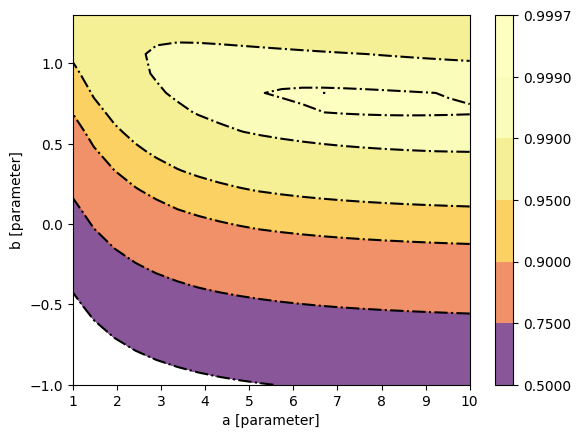

In [11]:
X,Y = np.meshgrid(b_list,a_list)
plt.contour(Y, X, output_data, levels=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9997], colors="black", linestyles='-.')
plt.contourf(Y, X, output_data, levels=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9997], cmap="inferno", alpha=0.7)
plt.colorbar()
plt.xlabel('a [parameter]')
plt.ylabel('b [parameter]')
plt.show()